In [3]:
import sqlite3

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

import alpha_hull

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Lecture des zones parents :

db_filename = '../data/arbres.db'
db = sqlite3.connect(db_filename)

cursor = db.cursor()

In [6]:
cursor.execute(""" SELECT DISTINCT code_parent, code_parent_desc FROM arbres  """)
zones_parent = { x[0]: {'name':x[1]} for x in cursor.fetchall()}

print( len(zones_parent) )

1445


In [7]:
list(zones_parent.keys())[0]

'ESP810'

In [272]:
for code_parent, infos in zones_parent.items():
    cursor.execute("""
        SELECT genre_bota, longitude, latitude FROM arbres 
        WHERE code_parent  = ?""", (code_parent, ))

    #nametuples = cursor.fetchmany(10)
    infos['arbres'] = cursor.fetchall()

In [366]:
R_Earth =  6371008  # m , volumétrique ?
def value_in_degree( meter ):
    return meter/R_Earth *180/np.pi

def value_in_meter( deg ):
    return deg*np.pi/180 * R_Earth

R_Earth =  6371008  # m , volumétrique ?
def convert_to_meter( array ):
    uv = array*np.pi/180*R_Earth
    uv = uv - uv.mean( axis=0 )
    return uv

def convert_to_degree( array, offset ):
    uv = array / R_Earth * 180/np.pi
    uv = uv + offset
    return uv

In [367]:
def get_coords_array( arbres ):
    XY = [ (tree[1], tree[2])  for tree in arbres ]
    XY = np.array( XY )
    return convert_to_meter( XY ), XY.mean( axis=0 )


def get_species( arbres ):
    spec = { tree[0] for tree in arbres }
    return spec

In [361]:
infos = list( zones_parent.values() )[17]
print( infos['name'], len(infos['arbres']), get_species(infos['arbres'])  )

Cité Chatelet Wash Poincare 63 {'Prunus', 'Magnolia', 'Tilia', 'Carpinus', 'Koelreuteria', 'Pinus', 'Platanus'}


In [362]:
points_list, offset_deg = get_coords_array( infos['arbres'] )

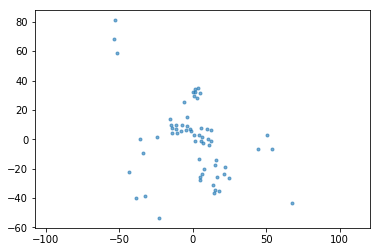

In [363]:
plt.plot( *points_list.T, '.', alpha=.6 )
plt.axis('equal');

In [364]:
n_points = 5
r_cercle = 3 # metre
thetas = np.linspace( 0, 2*np.pi, n_points+1 )[:-1]

added_point = []
for x, y in points_list:
    
    x_add = x + r_cercle * np.cos( thetas )
    y_add = y + r_cercle * np.sin( thetas )
    
    added_point.extend( zip( x_add, y_add ) )
    
added_point = np.array( added_point )

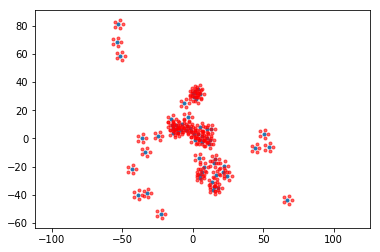

In [365]:
plt.plot( *points_list.T, '.' )
plt.axis('equal');

plt.plot( *added_point.T, '.r', alpha=.6 )
plt.axis('equal');

In [330]:
all_points = np.concatenate( (added_point, points_list) )

In [346]:
# Alpha hub
Rcritic = 16  # m
polygon = alpha_hull.alpha_shape( all_points, Rcritic  )[0]

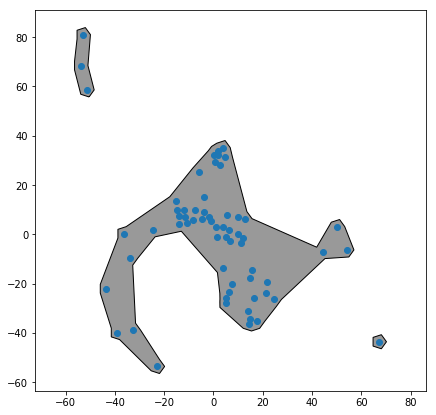

In [347]:
alpha_hull.plot_polygon( polygon  )
plt.plot( *points_list.T, 'o' )
plt.axis('equal');

In [344]:
# Rq: Delaunay ne marche pas avec les coords en degrée dec. ... 

In [355]:
polygon.geom_type

'MultiPolygon'

In [348]:
len( polygon )

3

In [326]:
list( polygon.boundary.coords )

NotImplementedError: Multi-part geometries do not provide a coordinate sequence

In [368]:
import shapely.geometry as geometry

In [369]:
geometry.mapping( polygon )

{'coordinates': [(((70.16421513841487, -43.53521473053843),
    (68.09126612153972, -46.38838427942389),
    (64.73716415529003, -45.298570487415844),
    (64.73716415529003, -41.77185897366101),
    (68.09126612153972, -40.68204518165297),
    (70.16421513841487, -43.53521473053843)),),
  (((-50.45715693320477, 55.74934545568979),
    (-53.81125889945446, 56.839159247697836),
    (-56.346704317663296, 66.72656281688208),
    (-56.346704317663296, 70.25327433063691),
    (-55.32840477168696, 79.27349545364225),
    (-55.32840477168696, 82.80020696739709),
    (-51.974302805437276, 83.89002075940513),
    (-49.90135378856212, 81.03685121051967),
    (-50.91965333453845, 68.4899185737595),
    (-48.384207916329615, 58.60251500457525),
    (-50.45715693320477, 55.74934545568979)),),
  (((-19.813690979382955, -53.56346973404288),
    (-21.88663999625811, -56.416639282928344),
    (-25.240741962507798, -55.3268254909203),
    (-38.086485150678584, -42.65306242611402),
    (-41.4405871169282

In [265]:
1/.15

6.666666666666667